In [ ]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

# from scipy.optimize import differential_evolution
# from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso  = 'SM2RAIN', '1dy'
product, time_reso = 'CHIRPS', '1dy'

yy_s, yy_e = 2002, 2023

years_num = yy_e - yy_s + 1
full_years = np.arange(yy_s, yy_e + 1)

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print(f'Opt method       : {param['opt_method']}')
print()

Read json file   : CHIRPS_1dy.json
ACF function     : mar
Number of threads: 22
Neighborhood area: 5x5
Opt method       : genetic



In [5]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy')

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc


<xarray.Dataset> Size: 2GB
Dimensions:  (time: 8035, lat: 240, lon: 260)
Coordinates:
  * time     (time) datetime64[ns] 64kB 2002-01-01 2002-01-02 ... 2023-12-31
  * lat      (lat) float32 960B 36.02 36.07 36.12 36.17 ... 47.87 47.92 47.97
  * lon      (lon) float32 1kB 6.025 6.075 6.125 6.175 ... 18.88 18.93 18.97
Data variables:
    PRE      (time, lat, lon) float32 2GB 0.0 0.0 0.0 0.0 ... 1.6 2.889 2.702
Attributes:
    description:  CHIRPS daily data for Italy region

In [ ]:
def downscale_clear(DATA_3h,la,lo,param):

    lat_c = lats[la]
    lon_c = lons[lo]

    Tr = np.array([5, 10, 20, 50, 100, 200])

    box_3h = DOWN_raw.create_box_v2(DATA_3h, lat_c, lon_c, param['npix'])

    all_nan_mask = box_3h.isnull().all(dim='time')
    num_all_nan_pixels = all_nan_mask.sum().item()

    if num_all_nan_pixels == 0:
    # all_nan_mask = box_3h.isnull().all(dim='time')
    # num_all_nan_pixels = all_nan_mask.sum().item()
    # total_pixels = all_nan_mask.size
    # nan_ratio = num_all_nan_pixels / total_pixels
    # if nan_ratio < 0.5:

        downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, 
                                    cor_method=param['corr_method'], toll=0.002,
                                    acf=param['acf'], save_yearly=True,
                                    maxmiss=40, clat=lat_c, clon=lon_c,
                                    opt_method=param['opt_method'], plot=False)

    else:
        print(f'Ignore: {la}, {lo}')
        downres = {}

    return downres

In [11]:
la = 166
lo = 247

In [12]:
downres = downscale_clear(PRE_1dy.PRE, la, lo, param)

Ignore: 166, 247
Downscaling Intermittency
Error in downscale_pwet: zero-size array to reduction operation minimum which has no identity
Downscaling the correlation
Computing the correlation
Downscaling pdf - global Weibull parameters
warning - downscaling function:: there is something wrong solving fsolve!
Downscaling pdf - yearly Weibull parameters
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wrong solving fsolve!
warning - downscaling function:: there is something wro

In [10]:
lat_c = lats[la]
lon_c = lons[lo]

Tr = np.array([5, 10, 20, 50, 100, 200])

box_3h = DOWN_raw.create_box_v2(PRE_1dy, lat_c, lon_c, param['npix'])
xdata = box_3h.where(box_3h >= -0.001) # set negative values to np.nan if any

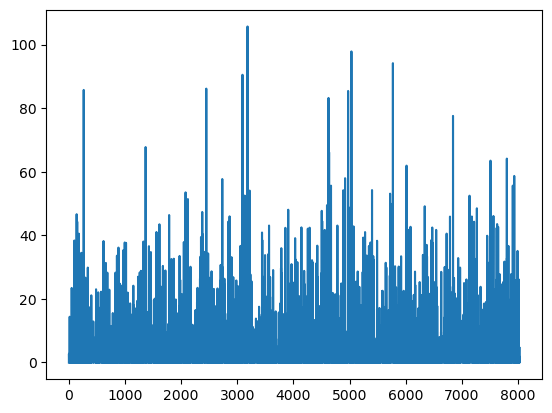

In [11]:
plt.plot(xdata.PRE.values[:,2,2])

In [15]:
# taylor = DOWN_raw.downscale_pwet(xdata.PRE, thresh=1, dt=param['dt'], L1=param['L1'],
#                     target_x=param['L0'], target_t=param['target_t'],
#                     origin_x=param['origin_x'], origin_t=param['origin_t'], ninterp=3000, plot='False')

In [ ]:
try:
    taylor = DOWN_raw.downscale_pwet(xdata.PRE, thresh=1, dt=param['dt'], L1=param['L1'],
                    target_x=0.0001, target_t=param['target_t'],
                    origin_x=param['origin_x'], origin_t=param['origin_t'], ninterp=1000, plot='False')
except Exception as e:
    taylor = {}
    taylor['beta'] = -999.9
    print(f"Error in downscale_pwet: {e}")

Error in downscale_pwet: zero-size array to reduction operation minimum which has no identity


In [15]:
taylor

{'beta': nan}

## Manual BETA

In [33]:
L1 = param['L1']
L0 = param['L0']
ninterp = 2000
target_x = param['target_x']
target_t = param['target_t']

In [20]:
xscales_km = xscales*L1
ntscales = np.size(tscales)
nxscales = np.size(xscales)
tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp)
pwmat_int = np.zeros((ninterp, nxscales))

for col in range(nxscales):
    pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

In [25]:
pw_min = np.min(pwets)
pw_max = np.max(pwets)
mypw = np.linspace(pw_min, pw_max, ninterp)

myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)

In [ ]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
        Tvec[jj] = tscales_int[myindices[ii,jj]]

    res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res[0]
    myX0[ii] = res[1]

ValueError: All-NaN slice encountered

In [32]:
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [43]:
myindices

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2000, 8035))

In [40]:
max_index

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

In [34]:
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?

ValueError: zero-size array to reduction operation minimum which has no identity

In [38]:
X0

array([], dtype=float64)

In [21]:
resbeta = DOWN_raw.Taylor_beta(pwets, xscales, tscales, L1=param['L1'],
                            target_x=param['target_x'], target_t=param['target_t'],
                            origin_x=param['origin_x'], origin_t=param['origin_t'],
                            ninterp=1000, plot='False')

# resbeta = DOWN_raw.Taylor_beta(pwets[1:,:], xscales, tscales[1:], L1=param['L1'],
#                             target_x=param['target_x'], target_t=param['target_t'],
#                             origin_x=param['origin_x'], origin_t=param['origin_t'],
#                             ninterp=3000, plot='False')

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
resbeta

NameError: name 'resbeta' is not defined